# 09. PyTorch Paper Replication

The goal is to turn a research paper of words into re-usable code.

In this notebook, we will replicate a vision transformer architecture from ViT paper: https://arxiv.org/abs/2010.11929

## 0. Get Setup

Let's import code we have previously written + required libraries

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 31.98 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Get Data

Goal is to replicate ViT architecture for the FoodVisionMini problem.

We will need the data of pizza, steak, sushi images that have been in use from all the past notebooks.

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

### 2.1 Data specific metrics

Numbers such as image size, batch size among others are referred to from the research paper itself.
Infered numbers are (below table 3):
- Image Size = 224
- Batch Size = 4096 (This is too big for google colab to handle), so we downscale to 32 itself

In [5]:
# Create image size
IMG_SIZE = 224 # Comes from the paper

# Create transforms
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Create the dataloaders with metrics found

In [6]:
# Create dataloaders with the gpu handleable batch size, so we start small

batch_size =32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=batch_size
)

len(train_dataloader), len(test_dataloader), len(class_names)

(8, 3, 3)

### 2.3 Visualize a single image

As we do everytime we will visualize one of the images from the train_dataloader

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

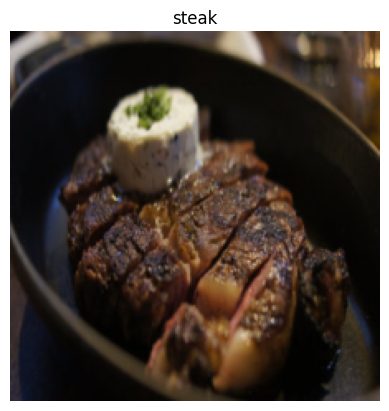

In [7]:
# Get the first batch from train_dataloader
batch = next(iter(train_dataloader))

# Get the first image and corresponding label
image, label = batch[0][0], batch[1][0]

# Correct the image to matplotlib format
image = image.permute(1,2,0)

# Visualize with matplotlib
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT: Overview

Looking at a whole ML research paper at first is intimidatingg.

So inorder to make it more understandable we break it down into smaller pieces:
- **Inputs** - What goes inot the model? (in our case, image tensors)
- **Outputs** - What comes out of the model/layer/black? (in our case, we want the model to output image classification labels)
- **Layers** - Takes an input, manipulates it with a function (in our case attension layers)
- **Blocks** - A collection of layers
- **Model** - A collection of blocks

### 3.1 ViT overview: pieces of the puzzle

- Figure 1: Visual overview of the architecture
- Four equations: math equations which define the functions of each layer/block
- Table 1/3: different hyperparameters for the architecture/training.
- Text

#### Figure 1
![](https://camo.githubusercontent.com/3c27690026aa45ef0ebedc755a228b9f1ed0e314f6843c33b10bbf666aa89548/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f7079746f7263682d646565702d6c6561726e696e672f6d61696e2f696d616765732f30382d7669742d70617065722d6669677572652d312d696e707574732d616e642d6f7574707574732e706e67)

#### Four equations
![](https://camo.githubusercontent.com/9c471a35ec52e0f6a8bec54f97e7d515c692cb2e36cae7a659555afe46127a2f/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f7079746f7263682d646565702d6c6561726e696e672f6d61696e2f696d616765732f30382d7669742d70617065722d666f75722d6571756174696f6e732e706e67)

#### Table 1
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

#### 3.1 VISION TRANSFORMER (VIT) - Describes each of the equation.

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image **x ∈ ℝ^(H×W×C)** into a sequence of flattened 2D patches **x_p ∈ ℝ^(N×(P²·C))**, where **(H, W)** is the resolution of the original image, **C** is the number of channels, **(P, P)** is the resolution of each image patch, and **N = HW/P²** is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size **D** through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches **(z₀⁰ = x_class)**, whose state at the output of the Transformer encoder **(z₀ᴸ)** serves as the image representation **y** (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to **z₀ᴸ**. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded self-attention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019). The MLP contains two layers with a GELU non-linearity.

1n pseudocode:

Equation 1:
```python
x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + [class_toke_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_N_pos]
```


Equation 2:
```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```


Equation 3:
```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Equation 4:
```python
y_pred = Linear_layer(LN_layer(x_output_MSA_block[0])) # For the final classification
```

- Training time: MLP -> one hidden layer
- Fine Tuning time: Linear layer

### 3.2 Architecture specifics

- ViT-B, ViT-L and ViT-H are all different sizes of the same model architecture.
- Layers: the number of transformer encoder layers. One ecoder layer is eqaution 1-3 above
- Hidden size $D$ - the embedding patch size, that is the vector that is mulltiplied into raw path values and no. of output vector elements
- MLP size - the number of hidden units/neurons in the MLP
- Head size - The size of MSA

## 4. Equation 1: Split data into patchs and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?
What's the output shape?

* Input shape: (224,224,3) -> height, width, color_channels of a single image
* Input image: $H\times{W}\times{C}$ (height, width, color_channels)
* Output image: **x_p ∈ ℝ^(N×(P²·C))**
* N = HW/P²
* P = 16 (from the paper, patch size)
* D: constant latent vector size = embedding dimension

In [8]:
# Create example values
height = 224
width =224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height*width)/(patch_size*patch_size))
number_of_patches

196

In [9]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape of a single 2D image: {embedding_layer_input_shape}')
print(f'Output shape of single 1D sequence of patches: {embedding_layer_output_shape} -> (number_of_patches , embedding_dimensions)')

Input shape of a single 2D image: (224, 224, 3)
Output shape of single 1D sequence of patches: (196, 768) -> (number_of_patches , embedding_dimensions)


### 4.2 Split image into patches

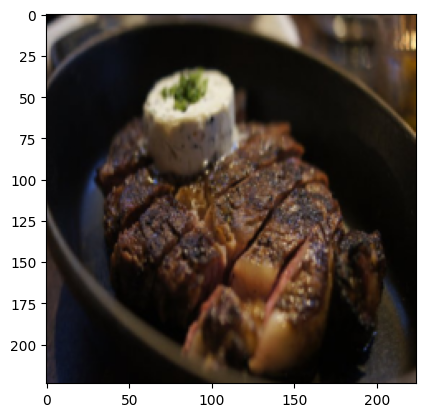

In [10]:
# View a single image
plt.imshow(image)

In [11]:
image.shape

torch.Size([224, 224, 3])

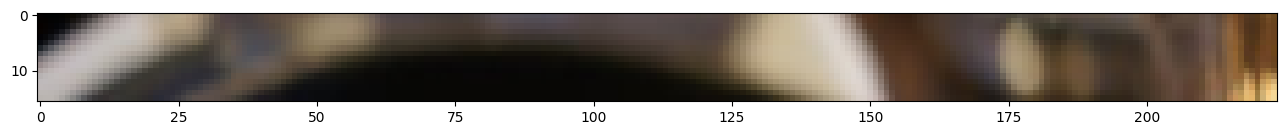

In [12]:
# Get the top row of the image

# Index into the top row and divide by patch size
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image[:patch_size, :, :])

Number of patches per row: 14.0
 Patch size: 16 pixels x 16 pixels


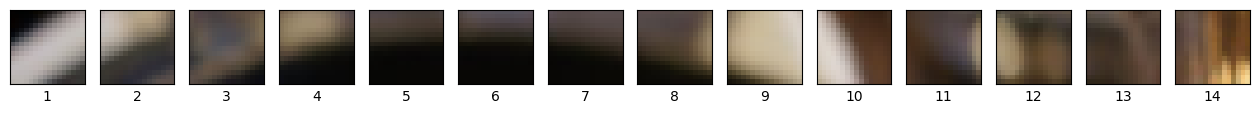

In [13]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible"
print(f'Number of patches per row: {num_patches}\n Patch size: {patch_size} pixels x {patch_size} pixels')


# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size, # one patch per col
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

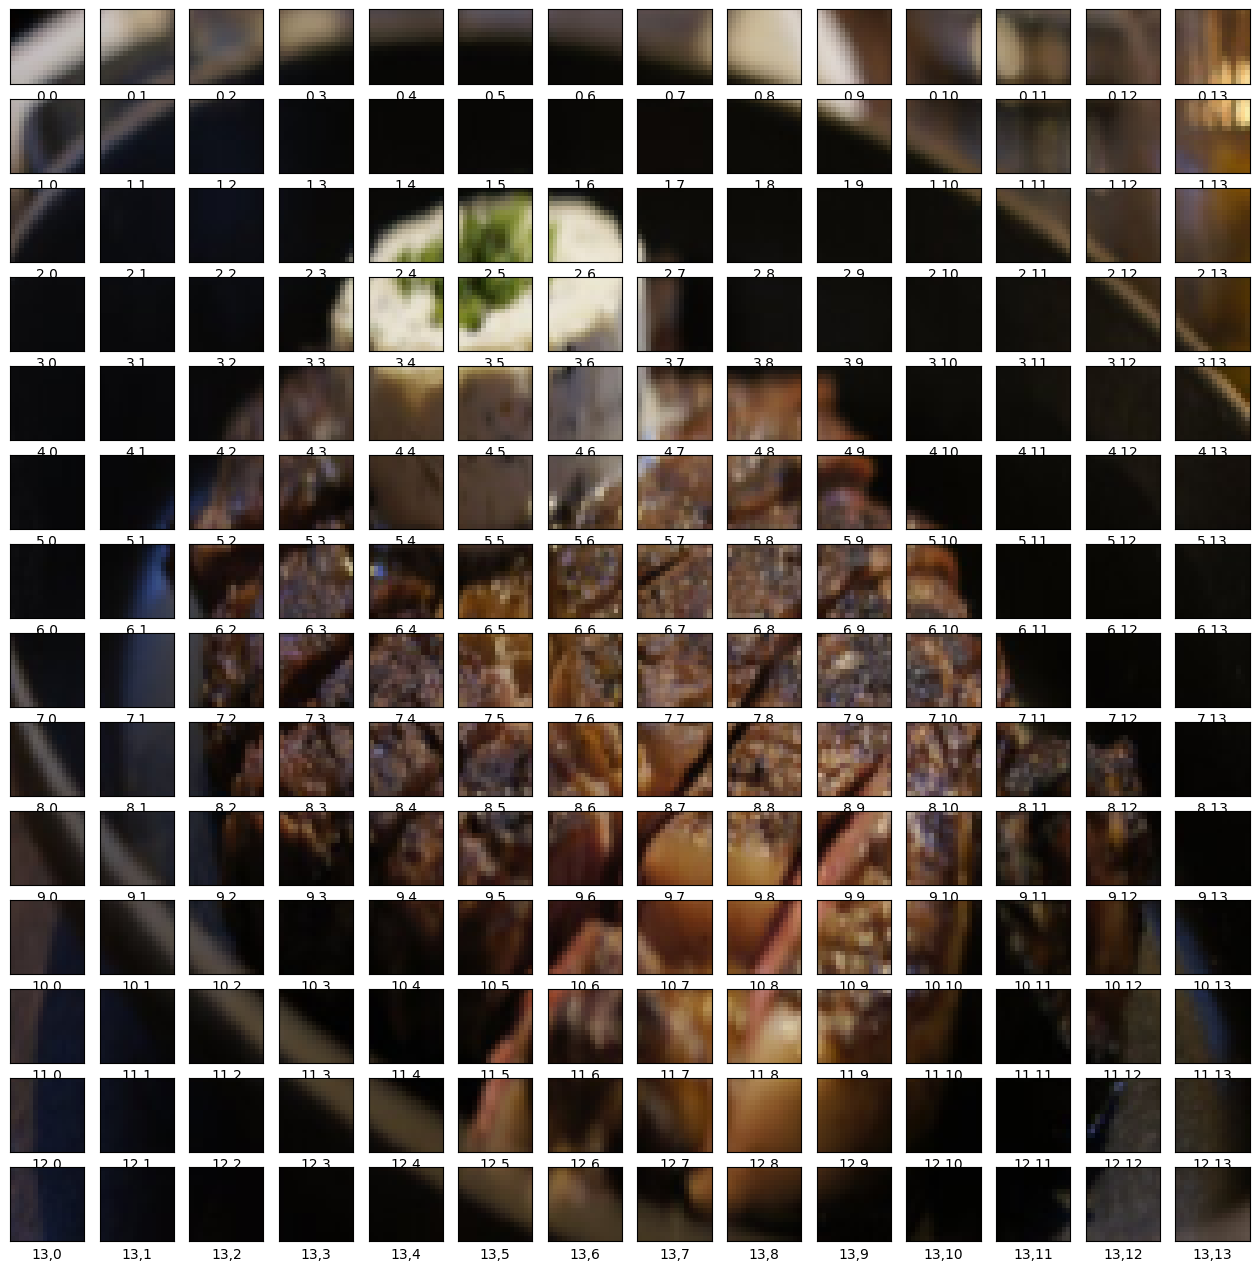

In [14]:
# Create code to diplay whole image as patches
fig, axs = plt.subplots(
    nrows=img_size//patch_size,
    ncols=img_size//patch_size,
    sharex=True,
    sharey=True,
    figsize=(patch_size,patch_size)
)

# Iterate through the rows
for i, patch_row in enumerate(range(0, img_size, patch_size)):
  # Iterate throught the cols
  for j, patch_col in enumerate(range(0, img_size, patch_size)):
    axs[i][j].imshow(image[patch_row:patch_row+patch_size, patch_col:patch_col+patch_size, :])
    axs[i][j].set_xticks([])
    axs[i][j].set_xlabel(f'{i},{j}')
    axs[i][j].set_yticks([])

In [15]:
print(f'Image size: {image.size}')
print(f'Image rows: {img_size//patch_size}')
print(f'Image cols: {img_size//patch_size}')
print(f'Patch size: {patch_size}x{patch_size}')
print(f'Number of patches {img_size//patch_size * img_size//patch_size}')

Image size: <built-in method size of Tensor object at 0x7a3f10cb4280>
Image rows: 14
Image cols: 14
Patch size: 16x16
Number of patches 196


### 4.3 Creating image patches and turning them into patch embeddings

Instead of creating patching manually, we can just re-purpose the Convolutional2D from Pytorch to do it for us by keeping `strid=kerner_size=patch_size`

And turn it into a vector using the nn.Flatten from PyTorch as well

In [16]:
# Create Conv2d layer to trun image into patches of learnable featuere maps (patchs of image)
from torch import nn

# set patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from ViT paper
conv2d = nn.Conv2d(
    in_channels=3, # Color channels
    out_channels=768, # From paper table 1, D-dime
    kernel_size=16,
    stride=16,
    padding=0,
)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

Text(0.5, 1.0, 'steak')

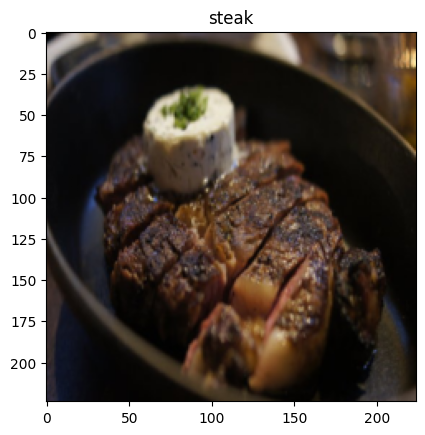

In [17]:
# View single image
plt.imshow(image)
plt.title(class_names[label])

In [18]:
image.unsqueeze(0).shape

torch.Size([1, 224, 224, 3])

In [19]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.permute(2,1,0).unsqueeze(0))
# We permute to change it into PyTorch needed format
# We unsqueeze to add batch size of 1
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


The code above has passed a single image, that is of batch_size = 1 into the `conv2d` layer.

Hence we get the output of `torch.Size([1, 768, 14, 14])`

`#[batch_size, D-dimension, num_of_patches_per_row, num_of_patches_per_col]`

Showing random convolutional feature maps from indexes: [91, 460, 417, 448, 327]


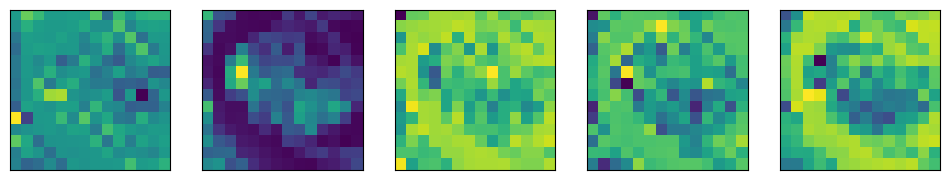

In [20]:
#plot random convolutional feature maps (embeddings)
import random
random_indexs = random.sample(range(0, 758), k=5)
print(f'Showing random convolutional feature maps from indexes: {random_indexs}')

# Create plot
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12,12))

for i, idx in enumerate(random_indexs):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])

In [21]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-2.4007e-01, -1.8362e-01, -7.2770e-02,  9.9922e-03,  1.3552e-02,
            1.6721e-02,  1.1147e-02,  6.2805e-03, -4.8710e-02, -1.1514e-01,
           -2.2174e-02, -3.0688e-02, -3.2463e-02, -6.3413e-03],
          [-2.8189e-01, -1.0839e-01,  5.7165e-03,  7.3332e-03,  1.2555e-02,
            2.0721e-02, -1.6901e-02, -8.1663e-02, -6.0853e-02, -6.1500e-02,
           -1.1416e-01,  3.9805e-03,  8.1707e-03,  1.3611e-02],
          [-1.5064e-01,  1.9925e-03, -4.9469e-03,  4.7152e-03, -7.4966e-03,
           -6.3930e-02, -9.6675e-02, -1.0645e-01, -6.5164e-02, -1.3117e-02,
           -7.9941e-03, -1.0097e-01,  1.6113e-02,  2.8239e-02],
          [-1.9630e-01,  1.4222e-02,  9.5146e-03, -1.6106e-01, -1.5343e-01,
           -1.2154e-01, -2.0676e-01, -5.9241e-02, -1.7459e-01, -4.8088e-02,
            9.5350e-03,  1.3050e-04, -7.5198e-02,  2.1702e-02],
          [-6.7677e-02,  2.0181e-02, -3.4251e-02, -2.2003e-01, -2.8845e-01,
           -9.1808e-02, -4.6956e-02, -1.4126e-01, -1.5774e-0

### 4.4 Flattening the patch embedding with the `torch.nn.Flatten()`

Right now we've a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [22]:
print(f'{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map,height, feature_map_width)')

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map,height, feature_map_width)


In [23]:
flatten = nn.Flatten(start_dim=2)
image_out_of_flatten = flatten(image_out_of_conv)
print(image_out_of_flatten.shape)

torch.Size([1, 768, 196])


In [24]:
# Permute the output to our need
image_out_of_flatten.permute(0,2,1).shape

torch.Size([1, 196, 768])

Input image shape: torch.Size([224, 224, 3])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened Image feature map shape: torch.Size([1, 768, 196])
After Permute: torch.Size([1, 196, 768])


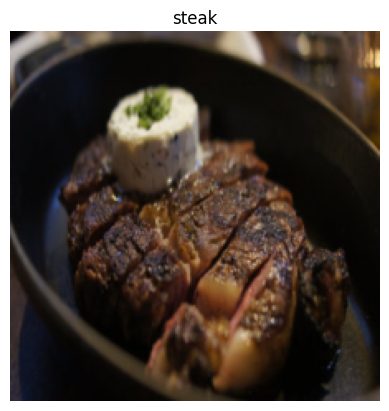

In [25]:
# Putting all together
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False)
print(f"Input image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.permute(2,1,0).unsqueeze(0)) # Pytorch image + add batch_dim
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattenend = flatten(image_out_of_conv)
print(f'Flattened Image feature map shape: {image_out_of_conv_flattenend.shape}')
image_out_of_conv_flattenend_permuted = image_out_of_conv_flattenend.permute(0,2,1)
print(f'After Permute: {image_out_of_conv_flattenend_permuted.shape}')

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

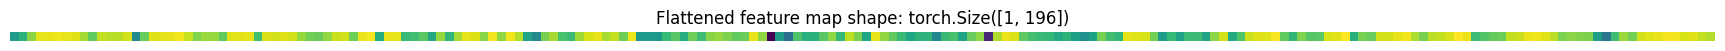

In [26]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattenend_permuted[:,:,0]

# Plot the flattened fature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` method that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [27]:
from torch import nn

# 1. Create a Class Patch Embedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperpaprameters
  def __init__(self, in_features: int=3,
               embedding_dim: int=768,
               patch_size: int=16) -> None:

     super().__init__()
     self.patch_size = patch_size
     # 3. Create a layer to turn image into embedded patches
     self.patcher = nn.Conv2d(
         in_channels=in_features,
         out_channels=embedding_dim,
         kernel_size=patch_size,
         stride=patch_size,
         padding=0
     )

     # 4. Create a layer to flatten output of conv2d layer
     self.flatten = nn.Flatten(start_dim=2)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0,    f'Input image size must be divisitble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}'

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flatten = self.flatten(x_patched)

    # 6. Reorder the tensor size to have the num_patches in the middle
    x_sequence_embedding = x_flatten.permute(0,2,1)
    return x_sequence_embedding

In [28]:
set_seeds()

# Create and instance of patch embedding layer
patchify = PatchEmbedding(
    in_features=3,
    patch_size=16,
    embedding_dim=768
)

# Pass a single image through patch embedding layer
print(f'Input image size: {image.permute(2, 1, 0).unsqueeze(0).shape}')
patch_embedded_image = patchify(image.permute(2, 1, 0).unsqueeze(0)) # Add a extra dimension for batch size
print(f'Output Image sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output Image sequence shape: torch.Size([1, 196, 768])


In [29]:
# Check if the assertion works
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_bad_tensor = torch.randn(1,3,225,225)

In [30]:
patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

In [31]:
patchify(rand_image_bad_tensor)

AssertionError: Input image size must be divisitble by patch size, image shape: 225, patch size: 16

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [32]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [33]:
# Create class token embeding as a learnable parameter with the same dimensions as embedding_dimensions (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True,)
class_token.shape

torch.Size([1, 1, 768])

In [34]:
# Pre-Pend the class token embedding in to the existing patch embedding
patch_embedded_image_with_class_token = torch.cat((class_token, patch_embedded_image),
                                                  dim=1 # number of patchs
                                                  )

print(f'Sequence of patch embeddings prepended with class tokens: {patch_embedded_image_with_class_token.shape} -> (batch_size, class_token + num_patches, D)')

Sequence of patch embeddings prepended with class tokens: torch.Size([1, 197, 768]) -> (batch_size, class_token + num_patches, D)


### 4.7 Creating a position embedding

Want to: Create a series of 1D learnable position embeddings and add them to the sequence of class token + patch embeddings

In [35]:
# Calculate number of patches -> N
number_of_patches = int((height*width)/patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_token.shape[-1]
embedding_dimension

768

In [36]:
# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, # batch size
                                             number_of_patches+1, # Number of rows in the col
                                             embedding_dimension, # D -> per vector entries
                                             ),
                                  requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [37]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_token, patch_embedded_image_with_class_token.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.6072,  0.3104, -0.2203,  ...,  0.4425, -0.0728,  0.0070],
          [-0.1224,  0.0133, -0.0453,  ...,  0.2797, -0.3320,  0.0342],
          ...,
          [-0.1414,  0.0141,  0.0139,  ...,  0.1043, -0.0831, -0.0162],
          [-0.1667,  0.0418, -0.0132,  ...,  0.0916, -0.1022,  0.0218],
          [-0.2806,  0.0948, -0.0260,  ...,  0.1491, -0.1479,  0.0492]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [38]:
# Add the position embedding to the class token and patch embedding
patch_and_position_embedding = position_embedding + patch_embedded_image_with_class_token
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.3928, 1.3104, 0.7797,  ..., 1.4425, 0.9272, 1.0070],
          [0.8776, 1.0133, 0.9547,  ..., 1.2797, 0.6680, 1.0342],
          ...,
          [0.8586, 1.0141, 1.0139,  ..., 1.1043, 0.9169, 0.9838],
          [0.8333, 1.0418, 0.9868,  ..., 1.0916, 0.8978, 1.0218],
          [0.7194, 1.0948, 0.9740,  ..., 1.1491, 0.8521, 1.0492]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

### 4.8 Putting it all together: from image to embedding

We have written code to turn an image to a flattened sequence of patch embedding, now will be run in the same cell

In [39]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print the shapes of the original image and the get the image dimensions
print(f'Image tensor shape: {image.shape}')
height, width, color_channels = image.shape

# 3. Get image tensor at a batch dimension
x = image.permute(2, 1, 0).unsqueeze(0)
print(f'Input image shape: {x.shape}')

# 4. Create patch embedding layer
patch_embedded_layer = PatchEmbedding(
    in_features=3,
    patch_size=patch_size,
    embedding_dim=768,
)

# 5. Pass input image through patch embedding layer
patch_embedding = patch_embedded_layer(x)
print(f'Patch embedded shape of image: {patch_embedding.shape}')

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size,
               1,
               embedding_dimension),
    requires_grad=True
)
print(f'Class Token embedding shape: {class_token.shape}')

# 7. Prepend class token to patch embedding
patch_embedded_class_token = torch.cat((class_token, patch_embedding),
                                       dim=1)
print(f'Class Token Prepended patch embeding shape: {patch_embedded_class_token.shape}')

# 8. Create the position embedding
num_patches = patch_embedded_class_token.shape[1]
position_embedding = nn.Parameter(
    torch.ones(
        batch_size,
        num_patches,
        embedding_dimension
    ),
    requires_grad=True
)
print(f'Position embedding shape: {position_embedding.shape}')

# 9. Add the Position embedding to the existing class token prepended Patch embedding
patch_and_position_embedding = patch_embedded_class_token + position_embedding
print(f'Patch and Position embedding: {patch_and_position_embedding.shape}')

Image tensor shape: torch.Size([224, 224, 3])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedded shape of image: torch.Size([1, 196, 768])
Class Token embedding shape: torch.Size([1, 1, 768])
Class Token Prepended patch embeding shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch and Position embedding: torch.Size([1, 197, 768])


### Equation 2: Multihead Self Attention (MSA Block)

- Which part of a sequence should a certain patch pay more attention to within the same sequence -> self attention
  - In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  - We want the ViT to learn this relationship/representation.
- We use built in `torch.nn.MultiHeadAttention()` and `torch.nn.LayerNorm()` to normalize the distributions of the intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
- Layer Norm is a technique to normalize the distributions of intermediate layers, that is samae mean and same std_dev, used for smoother training and faster convergence
  - We normalize along the embedding dimension -> That is the embedding the elements, 768 per vector from the patch_and_position

In [40]:
layer_norm = nn.LayerNorm(patch_and_position_embedding.shape)
layer_norm_out = layer_norm(patch_and_position_embedding)
layer_norm_out.shape

torch.Size([1, 197, 768])

In [41]:
num_heads = 12 # From the paper
msa_block = nn.MultiheadAttention(
    embed_dim=embedding_dimension,
    num_heads=num_heads
)
msa_output = msa_block(layer_norm_out,layer_norm_out,layer_norm_out)
msa_output[0].shape

torch.Size([1, 197, 768])

In [42]:
# Making the whole MSA Block combining msa_layer and norm_layer

from torch import nn

class MultiHeadSelfAttention(nn.Module):
  """
  Creates a multi-head self-attention block ('MSA block' for short)
  """
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12,
               msa_dropout: float=0.0) -> None:
     super().__init__()

     # Make a layer norm layer (LN)
     self.layer_norm = nn.LayerNorm(
         normalized_shape=embedding_dim, # We only need to normalize along the dim D and not for the whole batch hence we do not pass patch_and_position_embedding.shape
     )

     # Make a mutli head self attention layer (MSA)
     self.msa_layer = nn.MultiheadAttention(
         embed_dim=embedding_dim,
         num_heads=num_heads,
         dropout= msa_dropout,
         batch_first=True, # In our case we have (batch, patch_and_pos_embedding, D) -> D is the features we want to learn and patch_and_pos has the total number of vectors of dimension D
     )

  # Define forward pass
  def forward(self, x):
    x_layer_norm = self.layer_norm(x)
    x_msa_output, _ = self.msa_layer(x_layer_norm,
                                  x_layer_norm,
                                  x_layer_norm,
                                  need_weights=False)
    return x_msa_output

In [43]:
num_heads = 12 # From the paper

# Create a instance of MSA block

msa_block = MultiHeadSelfAttention(
    embedding_dim=embedding_dimension,
    num_heads=num_heads,
)
msa_output = msa_block(patch_and_position_embedding)
print(f'Input shape of MSA blocks: {patch_and_position_embedding.shape}')
print(f'Output shape of MSA blocks: {msa_output.shape}')

Input shape of MSA blocks: torch.Size([1, 197, 768])
Output shape of MSA blocks: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron Block (MLP Block)

- **MLP** = The MLP contains 2 layers with a GELU non-linearity (section 3.1).
  - MLP -> a quite broad term for a block with series of layers, which can be a single hidden layer or multiple layers.
  - Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` or in Tensorflow called `tf.kera.layers.Dense()`
  - GeLU in Pytorch -> `nn.GeLU()` in PyTorch
- **Dropout** = used after every dense, linear, connected layers. Except for qkv projections

  in pseudocode:
  ```python
  # MLP
  x = linear -> non-linear -> dropout -> linear -> non-linear -> dropout
  ```

In [44]:
layer_norm = nn.LayerNorm(embedding_dimension)
layer_norm_output = layer_norm(msa_output)
layer_norm_output.shape

torch.Size([1, 197, 768])

In [45]:
from torchvision import ops

mlp_layer = ops.MLP(
    in_channels=embedding_dimension,
    hidden_channels=[3072,3072],
    activation_layer=nn.GELU,
    )

mlp_output = mlp_layer(layer_norm_output)
mlp_output.shape

torch.Size([1, 197, 3072])

In [46]:
# Did not use the MLP built in block as that applies activation after every linear layer, but we want GELU only after the first one according to the paper

class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int=3072,
               dropout: float=0.3) -> None:
     super().__init__()
     self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
     self.mlp_layer = nn.Sequential(
      nn.Linear(in_features=embedding_dim, out_features=mlp_size),
      nn.GELU(),
      nn.Dropout(p=dropout),
      nn.Linear(in_features=mlp_size, out_features=embedding_dim),
      nn.Dropout(p=dropout)
      )

  # Forward pass
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp_layer(x)
    return x

In [47]:
embedding_dimension = 768
mlp_hidden_channels = 3072
dropout = 0.3
num_heads = 12

msa_block = MultiHeadSelfAttention(
    embedding_dim=embedding_dimension,
    num_heads=num_heads
)

mlp_block = MLPBlock(
    embedding_dim=embedding_dimension,
    mlp_size=mlp_hidden_channels,
    dropout=dropout,
)

msa_and_mlp_output = mlp_block(msa_block(patch_and_position_embedding))
print(f'Input shape of MLP block: {msa_output.shape}')
print(f'Output shape of MLP block: {msa_and_mlp_output.shape}')

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [48]:
mlp_block

MLPBlock(
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp_layer): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.3, inplace=False)
  )
)

## 7. Creating the Transformer Encoder

The Transformer encoder is the combination of lternation blocks of MSA (equation 2) and MLP (Equation 3)

Add residual inputs after each blocks of MLP and MSA

- Encoder = turn a sequence into learnable representation
- Decoder = go from learn representation into some sort of sequence
- Residual connections = add a layers input into its subsequent outputs, emabling the weights of deeper networks from vanishing or exploding

```python
# Tranformer Encoder
x_input -> msa_block -> msa_output + msa_residual -> mlp_block -> mlp_output + mlp_residual
```

### 7.1 Version 1 with all of the layers in the same class

In [49]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               msa_dropout: float= 0.0,
               mlp_size: int = 3072,
               mlp_dropout: float = 0.1) -> None:
     super().__init__()
     self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim),
     self.msa = nn.MultiheadAttention(
         embed_dim=embedding_dim,
         num_heads=num_heads,
         msa_dropout=msa_dropout,
     )
     self.mlp = nn.Sequential(
         nn.Linear(in_features=embedding_dim, out_features=mlp_size),
         nn.GELU(),
         nn.Dropout(p=mlp_dropout),
         nn.Linear(in_features=mlp_size, out_features=embedding_dim),
         nn.Dropout(p=mlp_dropout)
     )

  def forward(self, x):
    msa_output = self.msa(self.layer_norm(x), self.layer_norm(x), self.layer_norm(x))
    mlp_output = self.mlp(self.layer_norm(msa_output+x))
    return mlp_output + msa_output + x

### 7.2 Tranformer Encoder reusing the existing Blocks

In [50]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
               embedding_dim: int = 768, # Hidden size D from table 1
               num_heads: int = 12, # From table 1
               msa_dropout: float= 0.0, # From table 1
               mlp_size: int = 3072, # From table 1
               mlp_dropout: float = 0.1) -> None:
      super().__init__()
      self.msa = MultiHeadSelfAttention(
          embedding_dim=embedding_dim,
          num_heads=num_heads,
          msa_dropout=msa_dropout,
      )
      self.mlp = MLPBlock(
          embedding_dim=embedding_dim,
          mlp_size=mlp_size,
          dropout=mlp_dropout,
      )

    def forward(self, x):
      msa_output = self.msa(x)
      mlp_output = self.mlp(msa_output+x) # we add the x back for residual connection
      return mlp_output + msa_output + x # Residual connection here as well

In [51]:
# Create an instance of TransforeEncoderBlock()
transformer_encode_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(
    model=transformer_encode_block,
    input_size=(1,197,embedding_dimension), # The size of patch_and_position_embedding
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttention (msa)                     [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa_layer)              [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_layer)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.3 Create a Transformer Encoder layer with inbuilt PyTorch layer

So far we have created a transformer encoder by hand.

But PyTorch has already implemented ready to use Transformer Encoder Layers as they are too good

We can hence create the Transformer Encoder layer with pure pytorch layers

In [52]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_layer = nn.TransformerEncoderLayer(
    d_model=embedding_dimension,
    nhead=num_heads,
    dim_feedforward=mlp_hidden_channels,
    dropout=dropout,
    activation='gelu',
    batch_first=True,
    norm_first=True, # Layer norm is performed before MSA and MLP block, if False is done after both
)

torch_transformer_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
)

In [53]:
summary(
    model=torch_transformer_layer,
    input_size=(1,197,embedding_dimension), # The size of patch_and_position_embedding
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

Why spend all the this time recreating the transformer encorder when we could have just made it with a single PyTorch Layer?

Just for practice, customizability and learning of how things works behind the scene

Benefits of using a pre-built PyTorch layer?
- Lesser potential for errors
- Potentially better performance

## 8. Putting it all together to create ViT

In [54]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int = 224, # Table 3 from the ViT paper
               in_channels: int = 3,
               patch_size: int = 16,
               num_transformer_layers: int = 12, # Table 1 for "Layers" for ViT-Base
               embedding_dim: int=768, # D dimension from table 1 for ViT-Base
               num_heads: int=12, # Table 1
               mlp_dropout: float=0.1,
               mlp_size: int = 3072, # Table 1
               msa_dropout: float=0.0,
               embedding_dropout: int=0.1, # Dropout for patch and position embeddings
               num_claasses: int=1000
               ) -> None:
     super().__init__()

     # Make an assertion that the image size is compatible with the patch size
     assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

     # Calculate the number of patches (height * width/ patch^2)
     self.num_patches = (img_size*img_size) // patch_size**2

     # Create learnable class embedding (needs to go at front of sequence of patch embedding)
     self.class_embedding = nn.Parameter(
         data=torch.randn(1,1,embedding_dim),
         requires_grad=True,
     )

     # Create learnable position embedding
     self.position_embedding = nn.Parameter(
         data=torch.randn(1,self.num_patches+1,embedding_dim)
     )

     # Create embedding dropout value
     self.embedding_dropout = nn.Dropout(p=embedding_dropout)

     # Create patch embedding layer
     self.patch_embedding = PatchEmbedding(
         in_features=in_channels,
         embedding_dim=embedding_dim,
         patch_size=patch_size,
     )

     # Create the Transformer Encoder block
     self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
         embedding_dim=embedding_dim,
         num_heads=num_heads,
         mlp_size=mlp_size,
         mlp_dropout=mlp_dropout
     ) for _ in range(num_transformer_layers)])

     # Create classifier head
     self.classifier = nn.Sequential(
         nn.LayerNorm(normalized_shape=embedding_dim),
         nn.Linear(in_features=embedding_dim, out_features=num_claasses)
     )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 means infer the dimension from input

    # Get patch embedding (equation 1)
    x = self.patch_embedding(x)
    x = torch.cat((class_token,x), dim=1)  # Prepend the class learnable token to patch embedding (batch_size, num_patches+1, embedding_dim)
    x = self.position_embedding + x # Add the position embedding

    # Apply dropout after patch_pos_embedding
    x = self.embedding_dropout(x)

    # Pass the position and patch embedding through the 12 blocks of Transformer Encoder
    x = self.transformer_encoder(x)

    # Put the 0th index logit through the classifier
    x = self.classifier(x[:, 0]) # -> all batches and only the cls_token of it

    return x

In [55]:
batch_size = 32
embedding_dim = 768
class_embedding = nn.Parameter(
    data=torch.randn(1,1,embedding_dim),
    requires_grad=True,
)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1) # class_embedding is as of now declared of only one image, this copies the same embedding batch_size times over the batch_size dimension so all the images has it's unique copy of it
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [56]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1,3,224,224)

# Create an isntance of ViT with the number of classes we are working with (pizza, steak, sushi)
vit = ViT(num_claasses=len(class_names))

vit(random_image_tensor)

tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of a ViT model  

In [57]:
from torchinfo import summary

summary(
    model=vit,
    input_size=(1,3,224,224), # batch_size, color_channels, height, width
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                 [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    │ 

## 9. Setting up training code for custom ViT

We have replicated the ViT architecture, now let us see how it performs on our food vision mini data

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4: Training and Fine Tuning) with $B1$ value of 0.9 and $B2$ value of 0.999 and weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of weights (all theh weights of the model), to the loss function.

Regularization technique = prevents overfitting

In [58]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             weight_decay=0.1) # From paper

### 9.2 Creating a Loss function

The ViT paper doesn't actually mention what loss function they used. So since it is a multi-class classification we weill use the `torch.nn.CrossEntropyLoss()`

In [59]:
loss_fn = nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [62]:
from going_modular.going_modular import engine

set_seeds()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2290 | train_acc: 0.3867 | test_loss: 2.0355 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.2816 | train_acc: 0.3945 | test_loss: 2.8347 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2416 | train_acc: 0.4648 | test_loss: 2.5489 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.5684 | train_acc: 0.2852 | test_loss: 1.6442 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1676 | train_acc: 0.4297 | test_loss: 1.7108 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1398 | train_acc: 0.4219 | test_loss: 1.9344 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2277 | train_acc: 0.3984 | test_loss: 2.7581 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.3135 | train_acc: 0.3203 | test_loss: 1.7484 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2110 | train_acc: 0.2812 | test_loss: 1.0108 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2703 | train_acc: 0.2695 | test_loss: 1.0997 | test_acc: 0.2604


### 9.4 What our training setup is missing

How is our training setup different to the ViT paper?

We have replicated the model architecture correctly.

But what was different between our training procedure to get such poor results and ViT paper procedure to get such great results

Things the current implementation of ours is missing:

- Underfitting prevention:
  * Data - our setup uses far less data (225 vs 300M)
- Overfitting prevention:
  * Gradient clipping - Prevent gradients from getting too big
  * Learning rate warmup - start with a low learning rate and increase to a base LR
  * Learning rate Decay - as model is closer to convergence, reduce the learning rate

### 9.5 Plotting loss curves for our model

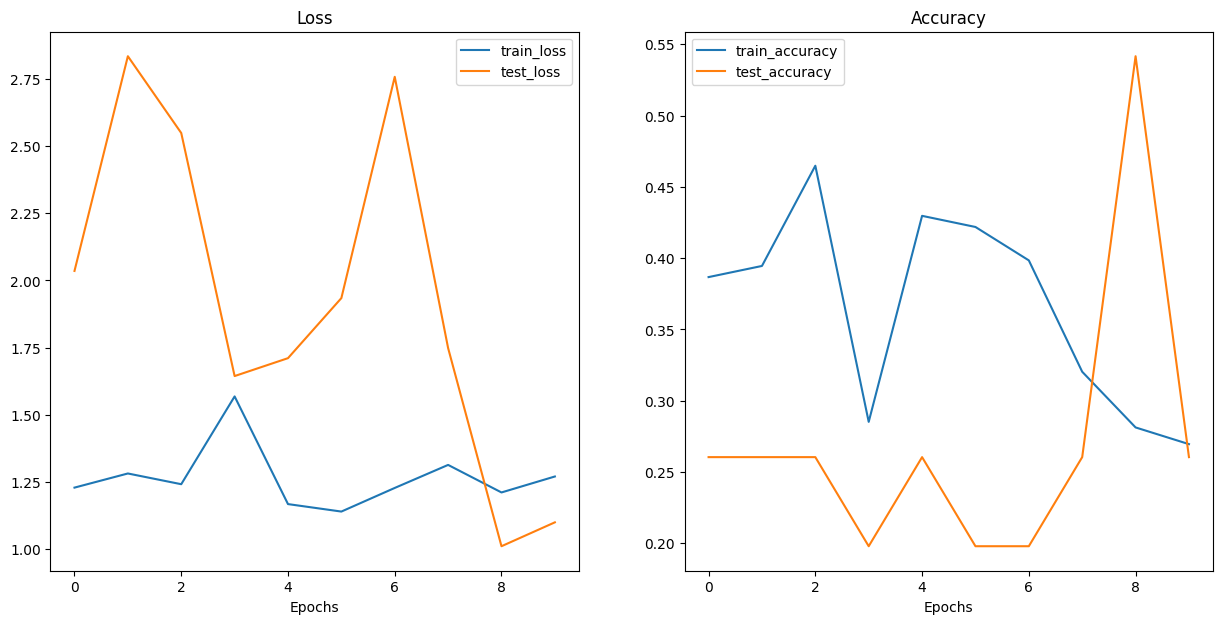

In [63]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pre-trained ViT from `torchvision.models`

It is often better to start with pretrained models and fine tune them for case specific tasks, rather than training from scratch.

Usually, fine tuning often achieves great results with less data

**Why use a pretrained model?**
- Limited Data
- limited training resources
- Better results (generally)

In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a featuer extractor)

In [94]:
# Get pretrained weights for ViT base from PyTorch
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # Coz DEFAULt is best available
vit_weights

ViT_B_16_Weights.IMAGENET1K_V1

In [95]:
# Pretrained vit model using PyTorch ViT
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [96]:
pretrained_vit.conv_proj

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [97]:
pretrained_vit.encoder

Encoder(
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (encoder_layer_0): EncoderBlock(
      (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=3072, out_features=768, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (encoder_layer_1): EncoderBlock(
      (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
    

In [98]:
pretrained_vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [99]:
# Freeze the encoder blocks (12 in Base model)
for params in pretrained_vit.encoder.parameters():
  params.requires_grad = False

# Freeze the convolutional projections
for params in pretrained_vit.conv_proj.parameters():
  params.requires_grad = False

# Replace the classifier head
pretrained_vit.heads = nn.Sequential(
    nn.Linear(
        in_features=embedding_dimension,
        out_features=len(class_names)
    )
).to(device)

In [100]:
summary(
    model=pretrained_vit,
    input_size=(1,3,224,224), # batch_size, color_channels, height, width
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, we want to transform the input data the same way it was trained on

In [101]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [102]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

### 10.4 Train feature extractor ViT Model

In [103]:
# Setup loss and criterion
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=0.001)

In [104]:
from going_modular.going_modular.engine import train

set_seeds()

pretrained_vit_results = train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7774 | train_acc: 0.7461 | test_loss: 0.5633 | test_acc: 0.8371
Epoch: 2 | train_loss: 0.3264 | train_acc: 0.9453 | test_loss: 0.3425 | test_acc: 0.8475
Epoch: 3 | train_loss: 0.2088 | train_acc: 0.9570 | test_loss: 0.2571 | test_acc: 0.8674
Epoch: 4 | train_loss: 0.1545 | train_acc: 0.9648 | test_loss: 0.2308 | test_acc: 0.8674
Epoch: 5 | train_loss: 0.1174 | train_acc: 0.9727 | test_loss: 0.2030 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.0985 | train_acc: 0.9766 | test_loss: 0.1980 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.0879 | train_acc: 0.9766 | test_loss: 0.2055 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.0834 | train_acc: 0.9844 | test_loss: 0.2023 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.0653 | train_acc: 0.9844 | test_loss: 0.1866 | test_acc: 0.9479
Epoch: 10 | train_loss: 0.0577 | train_acc: 0.9883 | test_loss: 0.1884 | test_acc: 0.9479


### 10.5 Plot the loss curves of the pretrained ViT feature extractor model

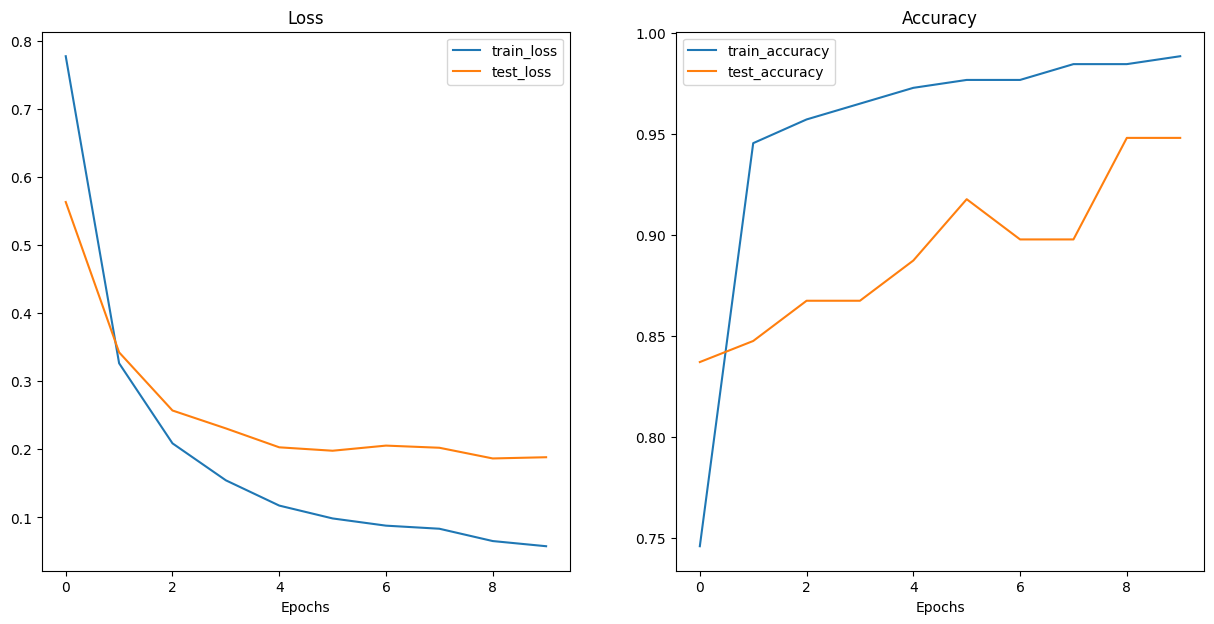

In [106]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing vit model

Now we've got a model that performs quite well, how bout we save it to file and check it's size to inspect if it is deployment ready.

Goal: Have a accurate food vision mini model which can be deployed on website -> Sammler model due to compute restrictions

In [107]:
# Save the model
from going_modular.going_modular.utils import save_model

save_model(
    model=pretrained_vit,
    target_dir='models',
    model_name='pretrained_ViT_feature_extractor_pizza_steak_sushi.pth'
)

[INFO] Saving model to: models/pretrained_ViT_feature_extractor_pizza_steak_sushi.pth


In [109]:
from pathlib import Path

# Get model size in bytes -> MB
pretrained_vit_size = Path('models/pretrained_ViT_feature_extractor_pizza_steak_sushi.pth').stat().st_size // (1024*1024)
print(f'Size of Pretrained ViT Feature extractor model size: {pretrained_vit_size} MB')

Size of Pretrained ViT Feature extractor model size: 327 MB


The pretrained ViT gets some of the best results we've seen so far on our FoodVision Mini problem, however, the model size is ~11x larger than the effnetb2 model which provides roughly the same accuracy (next best performing model)

Largers are harder to deploy as they tend to take longer for predictions and harder to deploy due to platform constraints

## 11. Predicting on a custom image

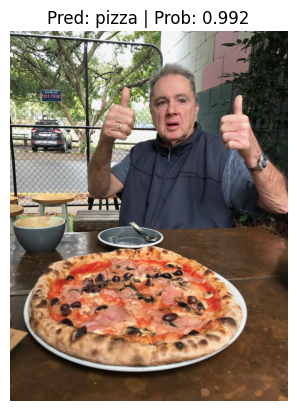

In [110]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
      # When downloading from GitHub, need to use the "raw" file link
      request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
      print(f"Downloading {custom_image_path}...")
      f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                  image_path=custom_image_path,
                  class_names=class_names)